Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2336 - val_loss: 0.1090
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1193 - val_loss: 0.1222
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1130 - val_loss: 0.1008
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0995 - val_loss: 0.0982
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0962 - val_loss: 0.1013
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1039 - val_loss: 0.0958
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1116 - val_loss: 0.0949
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0936 - val_loss: 0.0945
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845 - val_loss: 0.0949
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0912 - val_loss: 0.0957
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0929 - val_loss: 0.0953
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0816 - val_loss: 0.0946
Epoch 13/2

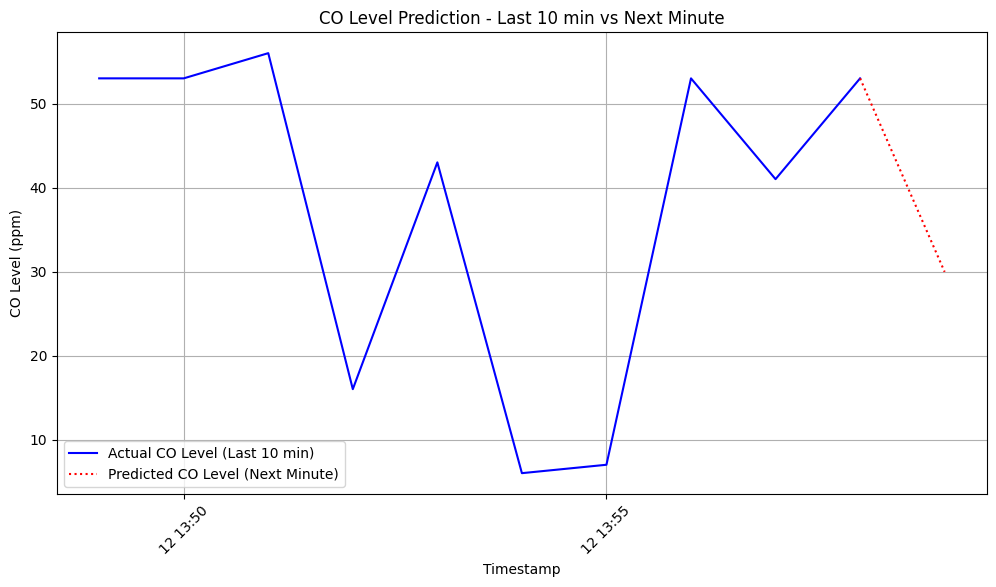

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# 📌 Load dataset
file_path = "Downloads/updated_co_sensor_data.csv"
df = pd.read_csv(file_path)

# 📌 Convert timestamp to datetime and sort values
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')

# 📌 Convert categorical columns to numeric (ON = 1, OFF = 0)
df['Fan_Status'] = df['Fan_Status'].map({'OFF': 0, 'ON': 1})
df['Blower_Status'] = df['Blower_Status'].map({'OFF': 0, 'ON': 1})

# 📌 Normalize CO Level (Scaling between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['CO_Level_ppm'] = scaler.fit_transform(df[['CO_Level_ppm']])

# 📌 Function to create sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):  # Predicting next 1 min
        X.append(data[i:i+time_steps])  # Last 10 minutes of data
        y.append(data[i+time_steps, 0])  # Predicting CO Level only
    return np.array(X), np.array(y)

# 📌 Prepare dataset for LSTM
dataset = df[['CO_Level_ppm', 'Fan_Status', 'Blower_Status']].values
time_steps = 10  # Last 10 minutes
X, y = create_sequences(dataset, time_steps)

# 📌 Train-test split (80-20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 📌 Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 📌 Build LSTM model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),  # ✅ Explicit Input Layer
    LSTM(64, return_sequences=False),
    Dense(1)  # Output = Predicted CO Level
])

# 📌 Compile the model
model.compile(optimizer='adam', loss='mse')

# 📌 Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 📌 Make predictions
predictions = model.predict(X_test)

# 📌 Inverse transform CO Level predictions
predictions_scaled = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📌 Determine Fan & Blower Status based on Predicted CO Levels
predicted_fan_status = np.where(predictions_scaled > 30, "ON", "OFF")
predicted_blower_status = np.where(predictions_scaled > 50, "ON", "OFF")

# 📌 Fix: Ensure All Arrays Are 1D Before Creating DataFrame
df_results = pd.DataFrame({
    'Timestamp': df['Timestamp'].iloc[-len(y_test):].values,
    'Actual_CO_Level': y_test_scaled.flatten(),
    'Predicted_CO_Level': predictions_scaled.flatten(),
    'Predicted_Fan_Status': predicted_fan_status.flatten(),
    'Predicted_Blower_Status': predicted_blower_status.flatten()
})

# 📌 Print the next minute's predicted values
print("\n🔹 Next Minute Predicted Values:")
print(df_results.tail(1))  # Show the last prediction

# 📌 Visualization: Last 10 min solid line, Predicted dotted line
plt.figure(figsize=(12, 6))

# Get last 10 minutes of actual data
last_10_actual = df_results.iloc[-11:-1]
last_timestamp_actual = last_10_actual['Timestamp']
last_co_actual = last_10_actual['Actual_CO_Level']

# Get next minute predicted
predicted_timestamp = df_results.iloc[-1]['Timestamp']
predicted_co_value = df_results.iloc[-1]['Predicted_CO_Level']

# 📌 Plot actual CO levels (last 10 min as solid line)
plt.plot(last_timestamp_actual, last_co_actual, label="Actual CO Level (Last 10 min)", color='blue', linestyle='solid')

# 📌 Plot predicted CO level (next 1 min as dotted line)
plt.plot([last_timestamp_actual.iloc[-1], predicted_timestamp], [last_co_actual.iloc[-1], predicted_co_value],
         label="Predicted CO Level (Next Minute)", color='red', linestyle='dotted')

plt.xlabel("Timestamp")
plt.ylabel("CO Level (ppm)")
plt.title("CO Level Prediction - Last 10 min vs Next Minute")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3473 - val_loss: 0.1955
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1514 - val_loss: 0.0981
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1073 - val_loss: 0.1236
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1091 - val_loss: 0.0990
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1055 - val_loss: 0.0983
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1000 - val_loss: 0.1000
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1031 - val_loss: 0.0958
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0988 - val_loss: 0.0953
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1031 - val_loss: 0.0950
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0929 - val_loss: 0.0949
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0895 - val_loss: 0.0949
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0977 - val_loss: 0.0946
Epoch 13/20


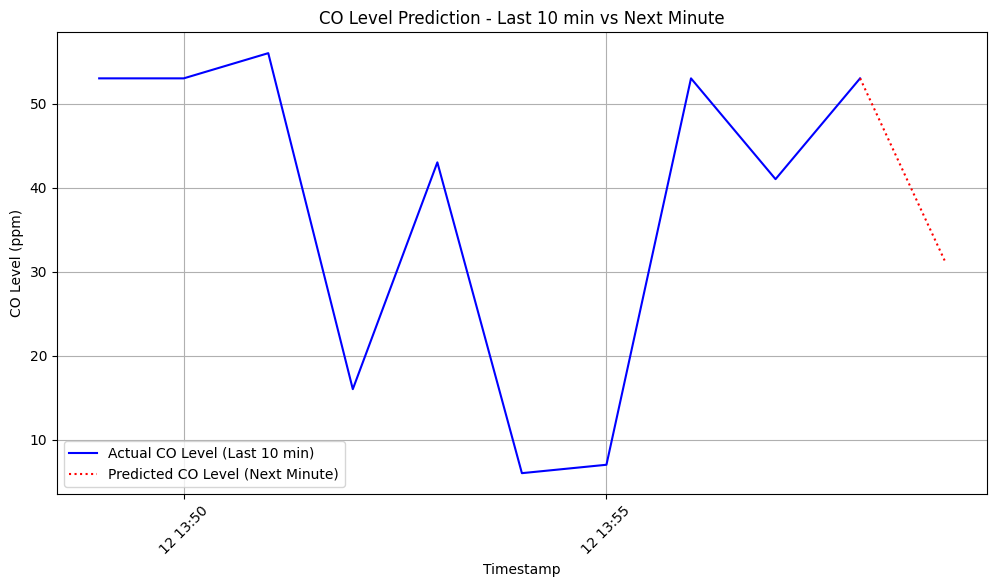

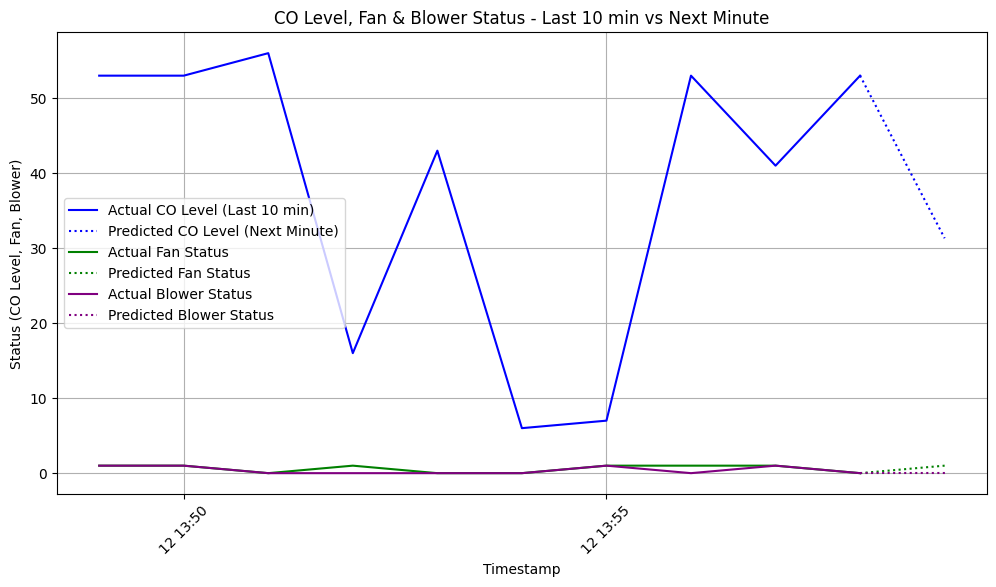

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# 📌 Load dataset
file_path = "downloads/updated_co_sensor_data.csv"
df = pd.read_csv(file_path)

# 📌 Convert timestamp to datetime and sort values
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')

# 📌 Convert categorical columns to numeric (ON = 1, OFF = 0)
df['Fan_Status'] = df['Fan_Status'].map({'OFF': 0, 'ON': 1})
df['Blower_Status'] = df['Blower_Status'].map({'OFF': 0, 'ON': 1})

# 📌 Normalize CO Level (Scaling between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['CO_Level_ppm'] = scaler.fit_transform(df[['CO_Level_ppm']])

# 📌 Function to create sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):  # Predicting next 1 min
        X.append(data[i:i+time_steps])  # Last 10 minutes of data
        y.append(data[i+time_steps, 0])  # Predicting CO Level only
    return np.array(X), np.array(y)

# 📌 Prepare dataset for LSTM
dataset = df[['CO_Level_ppm', 'Fan_Status', 'Blower_Status']].values
time_steps = 10  # Last 10 minutes
X, y = create_sequences(dataset, time_steps)

# 📌 Train-test split (80-20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 📌 Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 📌 Build LSTM model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),  # ✅ Explicit Input Layer
    LSTM(64, return_sequences=False),
    Dense(1)  # Output = Predicted CO Level
])

# 📌 Compile the model
model.compile(optimizer='adam', loss='mse')

# 📌 Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 📌 Make predictions
predictions = model.predict(X_test)

# 📌 Inverse transform CO Level predictions
predictions_scaled = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📌 Determine Fan & Blower Status based on Predicted CO Levels
predicted_fan_status = np.where(predictions_scaled > 30, "ON", "OFF")
predicted_blower_status = np.where(predictions_scaled > 50, "ON", "OFF")

# 📌 Fix: Ensure All Arrays Are 1D Before Creating DataFrame
df_results = pd.DataFrame({
    'Timestamp': df['Timestamp'].iloc[-len(y_test):].values,
    'Actual_CO_Level': y_test_scaled.flatten(),
    'Predicted_CO_Level': predictions_scaled.flatten(),
    'Predicted_Fan_Status': predicted_fan_status.flatten(),
    'Predicted_Blower_Status': predicted_blower_status.flatten()
})

# 📌 Print the next minute's predicted values
print("\n🔹 Next Minute Predicted Values:")
print(df_results.tail(1))  # Show the last prediction

# 📌 Visualization 1: Last 10 min solid line, Predicted dotted line for CO Level
plt.figure(figsize=(12, 6))

# Get last 10 minutes of actual data
last_10_actual = df_results.iloc[-11:-1]
last_timestamp_actual = last_10_actual['Timestamp']
last_co_actual = last_10_actual['Actual_CO_Level']

# Get next minute predicted
predicted_timestamp = df_results.iloc[-1]['Timestamp']
predicted_co_value = df_results.iloc[-1]['Predicted_CO_Level']

# 📌 Plot actual CO levels (last 10 min as solid line)
plt.plot(last_timestamp_actual, last_co_actual, label="Actual CO Level (Last 10 min)", color='blue', linestyle='solid')

# 📌 Plot predicted CO level (next 1 min as dotted line)
plt.plot([last_timestamp_actual.iloc[-1], predicted_timestamp], [last_co_actual.iloc[-1], predicted_co_value],
         label="Predicted CO Level (Next Minute)", color='red', linestyle='dotted')

plt.xlabel("Timestamp")
plt.ylabel("CO Level (ppm)")
plt.title("CO Level Prediction - Last 10 min vs Next Minute")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 📌 Visualization 2: CO Level, Fan Status, Blower Status in One Graph
plt.figure(figsize=(12, 6))

# 📌 Plot CO Level (Solid line for actual, Dotted for predicted)
plt.plot(last_timestamp_actual, last_co_actual, label="Actual CO Level (Last 10 min)", color='blue', linestyle='solid')
plt.plot([last_timestamp_actual.iloc[-1], predicted_timestamp], [last_co_actual.iloc[-1], predicted_co_value],
         label="Predicted CO Level (Next Minute)", color='blue', linestyle='dotted')

# 📌 Plot Fan Status (Solid for last 10 min, Dotted for predicted)
last_fan_actual = df['Fan_Status'].iloc[-11:-1]
plt.plot(last_timestamp_actual, last_fan_actual, label="Actual Fan Status", color='green', linestyle='solid')
plt.plot([last_timestamp_actual.iloc[-1], predicted_timestamp], [last_fan_actual.iloc[-1], 1 if predicted_fan_status[-1] == "ON" else 0],
         label="Predicted Fan Status", color='green', linestyle='dotted')

# 📌 Plot Blower Status (Solid for last 10 min, Dotted for predicted)
last_blower_actual = df['Blower_Status'].iloc[-11:-1]
plt.plot(last_timestamp_actual, last_blower_actual, label="Actual Blower Status", color='purple', linestyle='solid')
plt.plot([last_timestamp_actual.iloc[-1], predicted_timestamp], [last_blower_actual.iloc[-1], 1 if predicted_blower_status[-1] == "ON" else 0],
         label="Predicted Blower Status", color='purple', linestyle='dotted')

plt.xlabel("Timestamp")
plt.ylabel("Status (CO Level, Fan, Blower)")
plt.title("CO Level, Fan & Blower Status - Last 10 min vs Next Minute")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
